<a href="https://colab.research.google.com/github/kishanmodi/test/blob/main/s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install ortools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp

In [ ]:
def generate_daily_schedule_and_csv(demand_data_day, agents_data, shift_hours, shift_length_slots, break_start, day_index, output_csv_prefix="agent_schedule"):
    # Initialize solver
    solver = pywraplp.Solver.CreateSolver('SCIP')
    if not solver:
        raise Exception("Solver could not be created!")

    total_slots = len(demand_data_day)

    # Decision variables for each shift start time and type
    shifts = {}
    for s in shift_hours.keys():
        for t in range(total_slots - shift_length_slots[s] + 1):
            shifts[(s, t)] = solver.IntVar(0, 50, f'shift_{s}_start_{t}')

    # Objective: Prioritize high-demand coverage, but reduce penalties for flexibility
    high_demand_threshold = np.percentile(demand_data_day, 70)
    high_demand_slots = [i for i, d in enumerate(demand_data_day) if d >= high_demand_threshold]

    objective_terms = []
    for (s, t), shift_var in shifts.items():
        high_demand_overlap = len([slot for slot in range(t, t + shift_length_slots[s]) if slot in high_demand_slots])
        priority_weight = 1 - (high_demand_overlap / shift_length_slots[s]) * 0.5  # Adjust penalty weight here
        objective_terms.append(priority_weight * shift_var)
    solver.Minimize(solver.Sum(objective_terms))

    # Constraints: Ensure adequate coverage
    for j in range(total_slots):
        min_coverage = solver.Constraint(demand_data_day[j], solver.infinity())
        max_coverage = solver.Constraint(0, demand_data_day[j] + 5)  # Allow a bit more overstaffing if needed

        for (s, t), shift_var in shifts.items():
            if t <= j < t + shift_length_slots[s]:
                in_break = break_start[s] <= (j - t) < break_start[s] + 2
                if not in_break:
                    min_coverage.SetCoefficient(shift_var, 1)
                    max_coverage.SetCoefficient(shift_var, 1)

    # Add a constraint for ensuring coverage in the final slots (to prevent under-staffing in end hours)
    for t in range(total_slots - 2, total_slots):
        min_end_slot_coverage = solver.Constraint(demand_data_day[t], solver.infinity())
        for (s, t_start), shift_var in shifts.items():
            if t_start <= t < t_start + shift_length_slots[s]:
                min_end_slot_coverage.SetCoefficient(shift_var, 1)

    # Solve
    solver.SetTimeLimit(30000)  # 30 seconds
    status = solver.Solve()
    if status != pywraplp.Solver.OPTIMAL:
        raise Exception("No optimal solution found!")

    # Assign shifts to agents
    daily_shifts = []
    agent_index = 0
    for (s, t), var in shifts.items():
        shift_count = int(var.solution_value())
        if shift_count > 0:
            for _ in range(shift_count):
                if agent_index < len(agents_data):
                    start_slot = t
                    end_slot = t + shift_length_slots[s]
                    break_start_time = t + break_start[s]
                    break_start_hour = 7 + (break_start_time // 2)
                    break_start_minute = '00' if break_start_time % 2 == 0 else '30'
                    break_end_time = break_start_time + 2
                    break_end_hour = 7 + (break_end_time // 2)
                    break_end_minute = '00' if break_end_time % 2 == 0 else '30'

                    daily_shifts.append({
                        'agent_code': agents_data.loc[agent_index, 'agent_code'],
                        'day': f"Day {day_index + 1}",
                        'shift_type': s,
                        'start_time': f"{7 + (start_slot // 2)}:{'00' if start_slot % 2 == 0 else '30'}",
                        'end_time': f"{7 + ((end_slot) // 2)}:{'00' if end_slot % 2 == 0 else '30'}",
                        'break_time': f"{break_start_hour}:{break_start_minute} - {break_end_hour}:{break_end_minute}"
                    })
                    agent_index += 1

    # Create a DataFrame for the day's shifts
    daily_schedule_df = pd.DataFrame(daily_shifts)
    daily_schedule_df.to_csv(f"{output_csv_prefix}_day_{day_index + 1}.csv", index=False)  # Save as CSV

    # Print the daily schedule
    print(f"Daily schedule for Day {day_index + 1}:")
    print(daily_schedule_df)
    return daily_schedule_df



def generate_weekly_schedule_and_plot(demand_data_weekly, agents_data, shift_hours=None, shift_length_slots=None, break_start=None, output_csv_prefix="agent_schedule"):
    # Default shift parameters
    if shift_hours is None:
        shift_hours = {'7_hour': 7, '8_hour': 8, '9_hour': 9}
    if shift_length_slots is None:
        shift_length_slots = {'7_hour': 14, '8_hour': 16, '9_hour': 18}
    if break_start is None:
        break_start = {'7_hour': 5, '8_hour': 6, '9_hour': 7}

    weekly_schedule = []
    total_slots = len(demand_data_weekly[0])  # Assuming each day has the same number of slots

    # Create a daily schedule and collect the weekly schedule
    for day_index, demand_data_day in enumerate(demand_data_weekly):
        daily_schedule_df = generate_daily_schedule_and_csv(demand_data_day, agents_data, shift_hours, shift_length_slots, break_start, day_index, output_csv_prefix)
        weekly_schedule.extend(daily_schedule_df.to_dict('records'))  # Collect all shifts for the week

    # Aggregate final schedule for the entire week
    weekly_schedule_df = pd.DataFrame(weekly_schedule)
    weekly_schedule_df['agent_code'] = weekly_schedule_df['agent_code'].astype(str)
    weekly_schedule_df['hours_worked'] = 0

    # Calculate hours worked for each agent in the week
    for index, row in weekly_schedule_df.iterrows():
        shift_length = shift_length_slots[row['shift_type']]
        hours_worked = shift_length / 2  # Convert to hours (half-hour slots)
        weekly_schedule_df.at[index, 'hours_worked'] = hours_worked

    # Aggregate hours worked per agent
    agent_hours = weekly_schedule_df.groupby('agent_code')['hours_worked'].sum().reset_index()

    # Print final weekly hours worked per agent
    print("Final weekly hours worked per agent:")
    print(agent_hours)

    # Initialize the scheduled agents matrix for the entire week
    scheduled_agents_week = np.zeros((6, total_slots))

    # Generate the daily schedule and plot for each day
    for day_index in range(6):
        day_schedule = weekly_schedule_df[weekly_schedule_df['day'] == f"Day {day_index + 1}"]

        # Initialize daily schedule for agents
        for _, row in day_schedule.iterrows():
            shift_type = row['shift_type']
            start_slot = int(row['start_time'].split(":")[0]) * 2 + (1 if row['start_time'].split(":")[1] == '30' else 0) - 14
            for i in range(start_slot, start_slot + shift_length_slots[shift_type]):
                if i < total_slots:
                    scheduled_agents_week[day_index][i] += 1

        # Plot demand vs. scheduled agents for the current day
        plt.figure(figsize=(12, 6))
        plt.plot([f"{7 + i//2}:{'00' if i % 2 == 0 else '30'}" for i in range(total_slots)], demand_data_weekly[day_index], label="Demand", linestyle='--', color='red')
        plt.plot([f"{7 + i//2}:{'00' if i % 2 == 0 else '30'}" for i in range(total_slots)], scheduled_agents_week[day_index], label="Scheduled Agents", marker='x', color='blue')

        plt.xticks(rotation=45)
        plt.xlabel("Time")
        plt.ylabel("Number of Agents / Demand")
        plt.title(f"Demand vs. Scheduled Agents for Day {day_index + 1}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Plot the aggregated weekly schedule
    time_labels = [f"{7 + i//2}:{'00' if i % 2 == 0 else '30'}" for i in range(total_slots)]
    plt.figure(figsize=(12, 6))
    for day_index in range(6):
        plt.plot(time_labels, scheduled_agents_week[day_index], label=f'Day {day_index + 1}', marker='x')

    plt.xticks(rotation=45)
    plt.xlabel("Time")
    plt.ylabel("Number of Agents")
    plt.title("Demand vs. Scheduled Agents for the Entire Week")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Daily schedule for Day 1:
   agent_code    day shift_type start_time end_time     break_time
0     Agent_1  Day 1     7_hour       7:00    14:00   9:30 - 10:30
1     Agent_2  Day 1     7_hour       7:00    14:00   9:30 - 10:30
2     Agent_3  Day 1     7_hour       7:00    14:00   9:30 - 10:30
3     Agent_4  Day 1     7_hour       7:00    14:00   9:30 - 10:30
4     Agent_5  Day 1     7_hour       7:30    14:30  10:00 - 11:00
5     Agent_6  Day 1     7_hour       7:30    14:30  10:00 - 11:00
6     Agent_7  Day 1     7_hour       8:00    15:00  10:30 - 11:30
7     Agent_8  Day 1     7_hour       8:00    15:00  10:30 - 11:30
8     Agent_9  Day 1     7_hour       8:30    15:30  11:00 - 12:00
9    Agent_10  Day 1     7_hour       9:00    16:00  11:30 - 12:30
10   Agent_11  Day 1     7_hour       9:30    16:30  12:00 - 13:00
11   Agent_12  Day 1     8_hour       9:00    17:00  12:00 - 13:00
12   Agent_13  Day 1     8_hour       9:30    17:30  12:30 - 13:30
13   Agent_14  Day 1     8_hour     

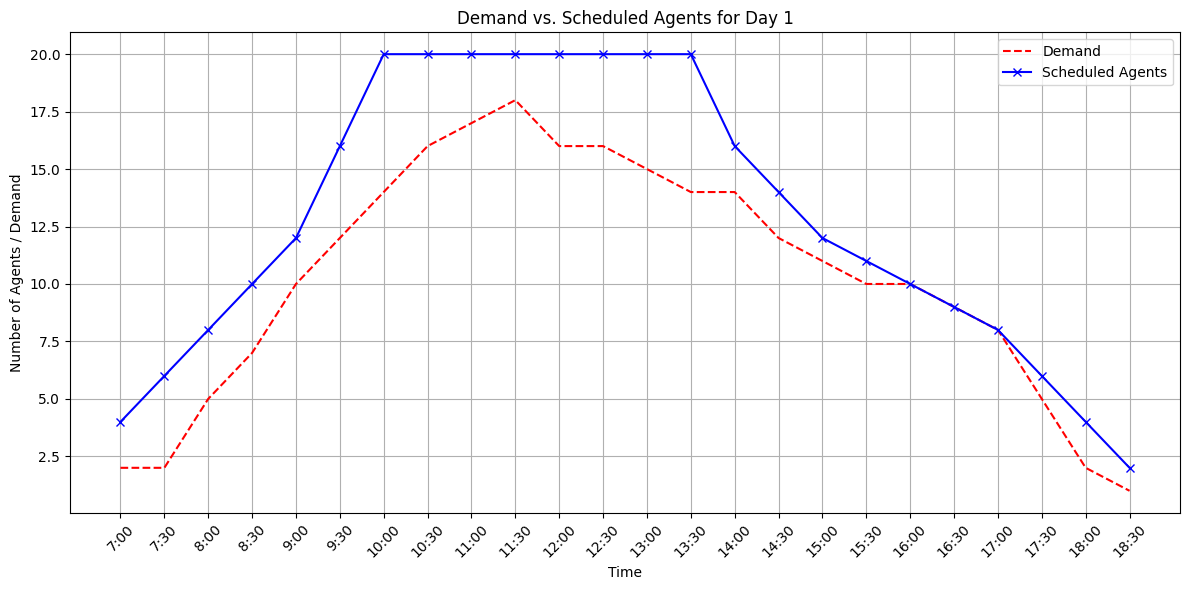

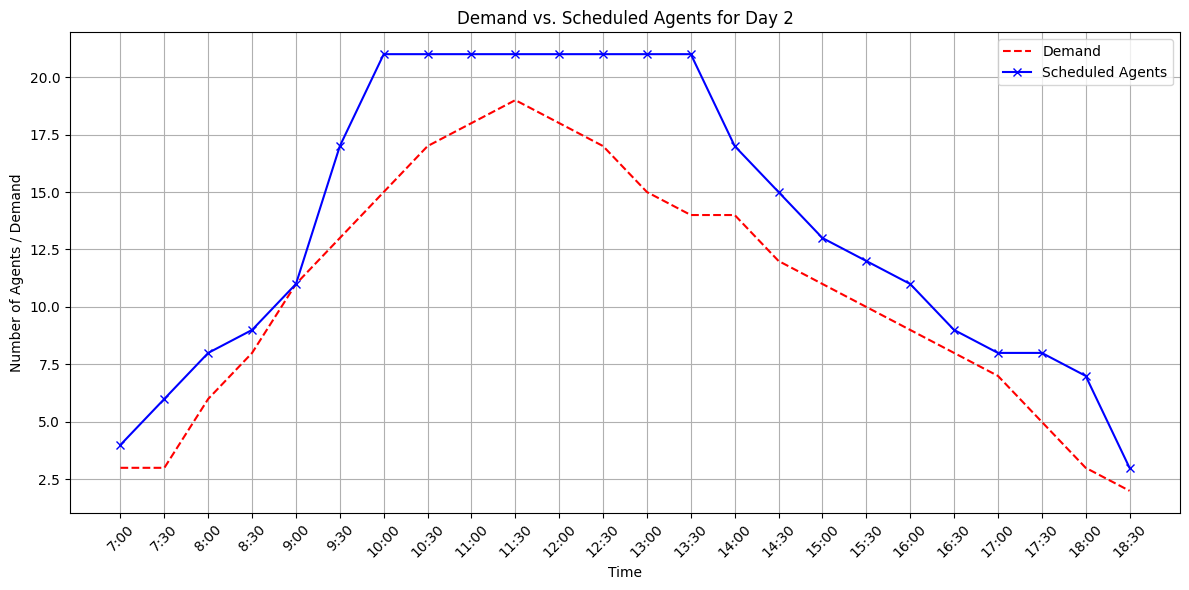

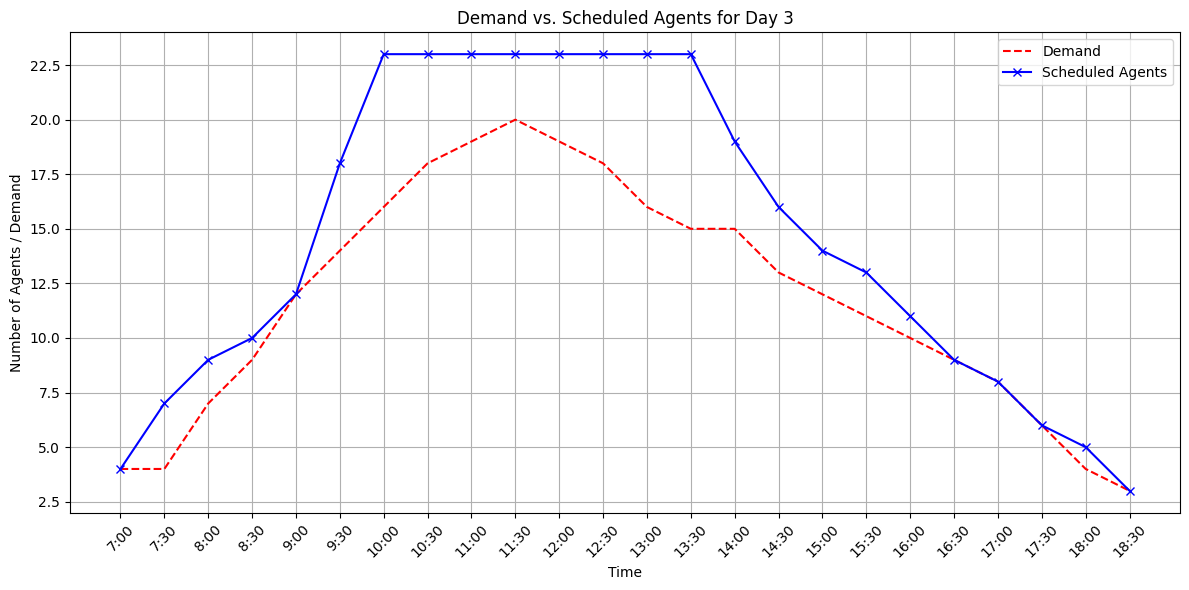

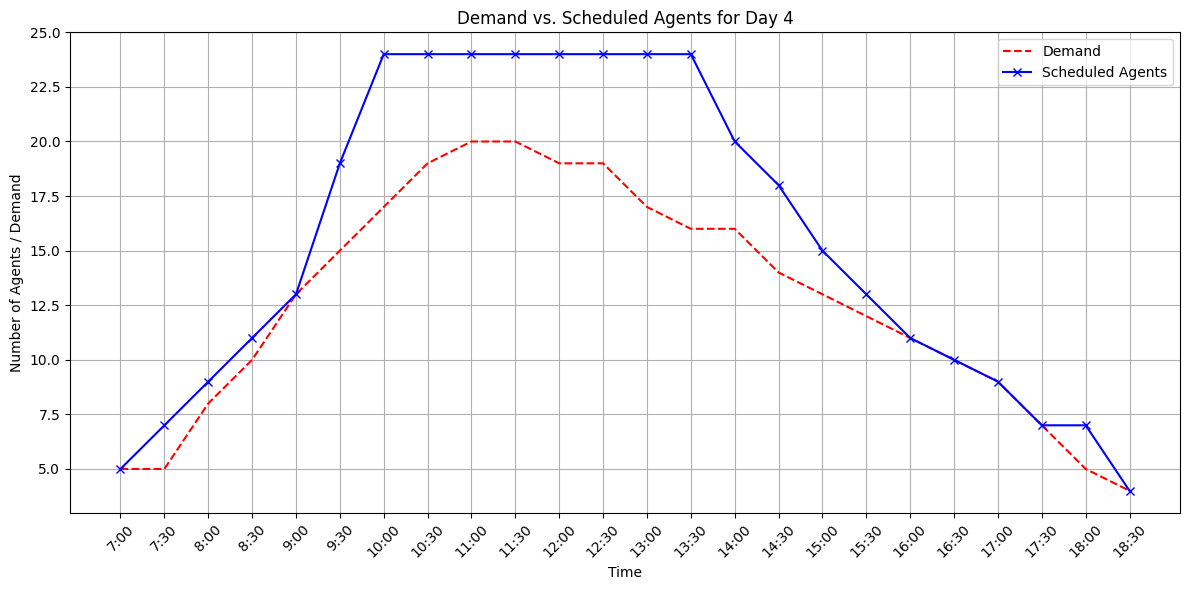

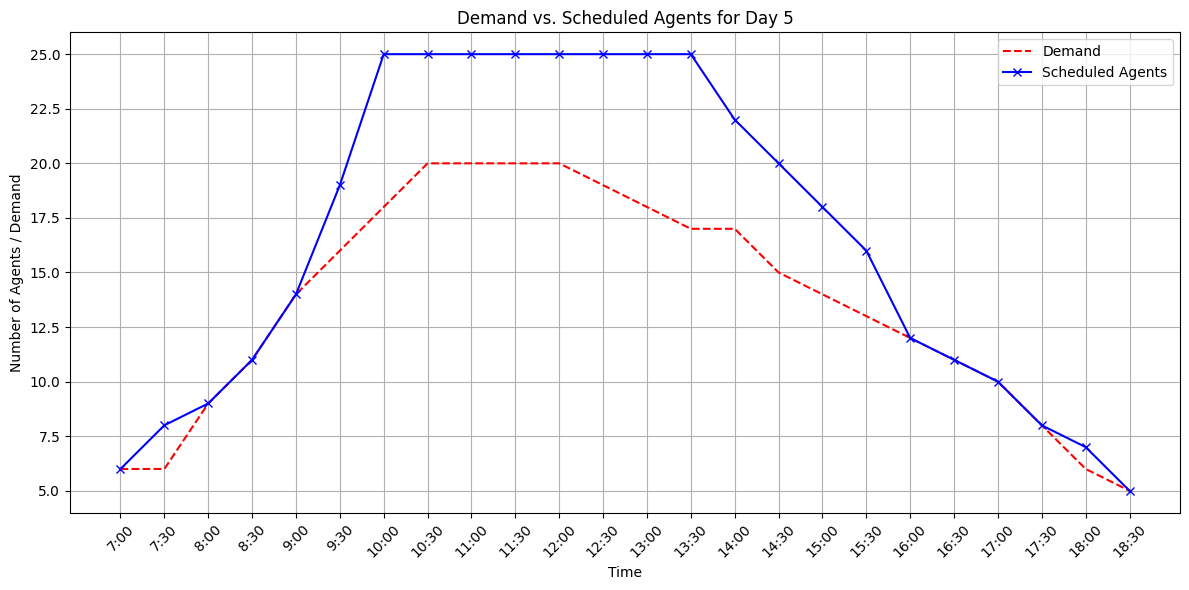

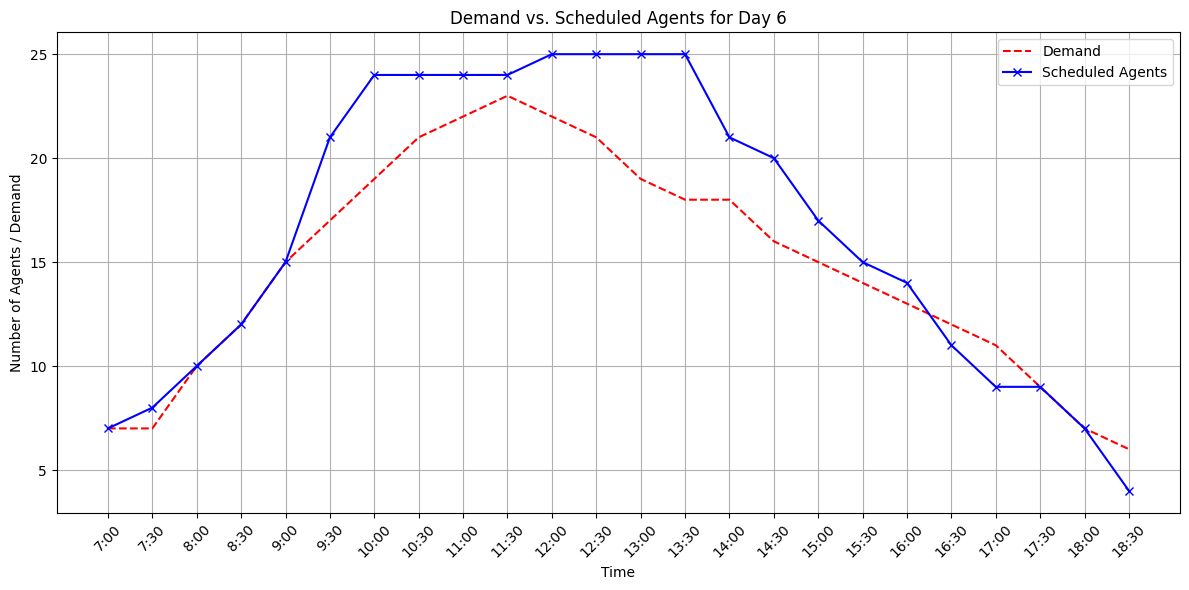

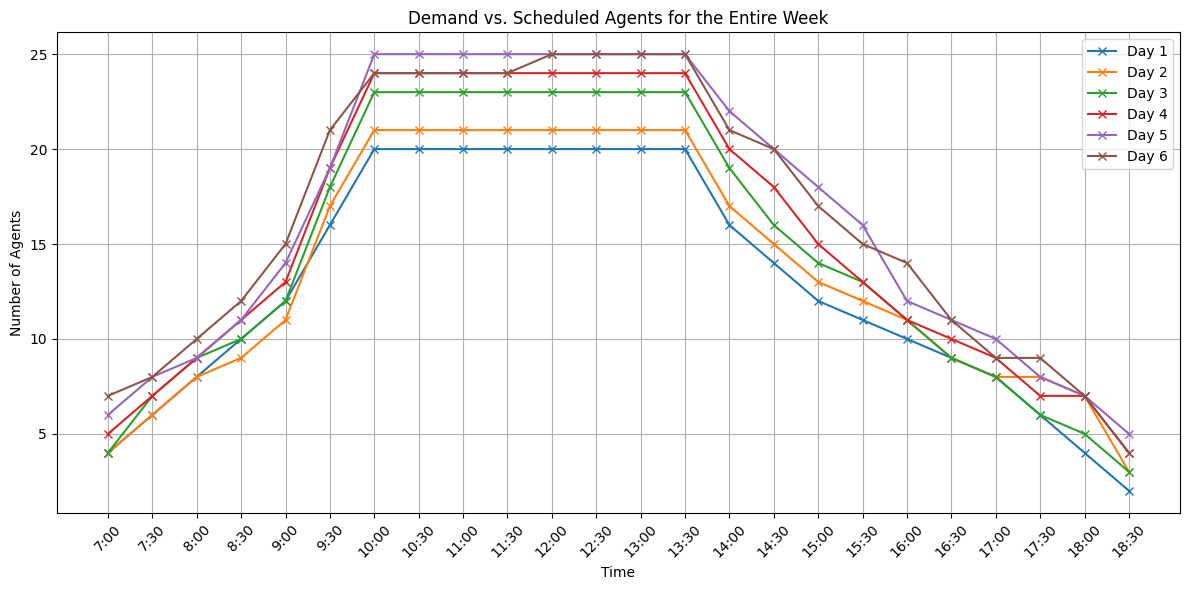

In [ ]:
    # Assume `agents_data` is a DataFrame containing agent information (agent_code, etc.)
    agents_data = pd.DataFrame({
        'agent_code': [f'Agent_{i+1}' for i in range(25)],
    })

    demand_data_weekly = [
            [2, 2, 5, 7, 10, 12, 14, 16, 17, 18, 16, 16, 15, 14, 14, 12, 11, 10, 10, 9, 8, 5, 2, 1],  # Day 1
            [3, 3, 6, 8, 11, 13, 15, 17, 18, 19, 18, 17, 15, 14, 14, 12, 11, 10, 9, 8, 7, 5, 3, 2],  # Day 2
            [4, 4, 7, 9, 12, 14, 16, 18, 19, 20, 19, 18, 16, 15, 15, 13, 12, 11, 10, 9, 8, 6, 4, 3],  # Day 3
            [5, 5, 8, 10, 13, 15, 17, 19, 20, 20, 19, 19, 17, 16, 16, 14, 13, 12, 11, 10, 9, 7, 5, 4],  # Day 4
            [6, 6, 9, 11, 14, 16, 18, 20, 20, 20, 20, 19, 18, 17, 17, 15, 14, 13, 12, 11, 10, 8, 6, 5],  # Day 5
            [7, 7, 10, 12, 15, 17, 19, 21, 22, 23, 22, 21, 19, 18, 18, 16, 15, 14, 13, 12, 11, 9, 7, 6],  # Day 6
        ]
    generate_weekly_schedule_and_plot(demand_data_weekly, agents_data)